In [3]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from timeit import default_timer as timer


In [4]:
train_data_file = "Brunel_BdJPsiKs_MagU_30k.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value"] , axis=1).astype(np.float64)

target = data.is_downstream_reconstructible
features = features.drop(features.columns[0], axis=1)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.447929,1849.101146,1083.522737,27.0,0.0,12.0,-1418.736880,-143.095899,-0.722093,-0.038671
1,0.354945,10085.622823,1345.148537,24.0,0.0,12.0,-393.699553,-284.193871,-0.129122,-0.037920
2,2.906524,2441.534682,1013.888408,24.0,0.0,12.0,-834.004914,-270.235334,-0.456235,-0.015198
3,3.234916,2604.073941,904.097232,24.0,0.0,12.0,-475.119652,-230.380918,-0.369728,-0.018967
4,0.842265,2644.554049,1068.602364,23.0,0.0,12.0,-899.187260,-101.826800,-0.440227,-0.036610


In [5]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=np.abs(data['seed_x'])
    out["abs_seed_y"]=np.abs(data['seed_y'])
    out["abs_seed_tx"]=np.abs(data['seed_tx'])
    out["abs_seed_ty"]=np.abs(data['seed_ty'])
    out['seed_r'] = np.sqrt(np.square(data.seed_x) +np.square(data.seed_y))    
    out['pseudo_rapidity'] = np.arctanh(data.seed_pt/data.seed_p)
    return out

In [6]:
features = basic_transforamtion(features)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.2, random_state=12)

In [9]:
X_valid = (X_valid - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [10]:
datasets={
    "train":TensorDataset(torch.Tensor(np.array(X_train.values)).to(device), torch.Tensor(np.array(Y_train.values, dtype=np.uint8)).to(device)),
    "valid":TensorDataset(torch.Tensor(np.array(X_valid.values)).to(device), torch.Tensor(np.array(Y_valid.values, dtype=np.uint8)).to(device))
}


In [11]:
datasets["valid"].__getitem__(0)

(tensor([ 1.3830, -0.0121, -0.0142,  0.2311, -0.5876, -1.2248,  0.7084, -2.9106,
         -1.5882, -2.1764, -0.0873,  3.0382,  1.2874,  2.0683,  1.7239,  1.3785],
        device='cuda:0'), tensor(0., device='cuda:0'))

In [49]:
dataloaders = { 
    'train':DataLoader(datasets["train"], 
                   batch_size=64,
                   shuffle=True,
                    num_workers=0),
    'valid':DataLoader(datasets["valid"],
                      batch_size=128,
                      shuffle=False,
                      num_workers=0)
}

In [30]:
for batch in dataloaders["train"]:
    print("features", batch[0], len(batch[0]))
    print("target", batch[1], len(batch[1]))
    break

features tensor([[-0.0838, -0.0093, -0.0074,  ...,  0.3481, -0.2977, -0.2139],
        [ 0.1985, -0.0115, -0.0089,  ..., -0.5327,  0.8411,  1.2835],
        [ 0.3355, -0.0121, -0.0106,  ..., -0.2787,  1.6890,  2.8756],
        ...,
        [-1.3622,  0.0001, -0.0085,  ..., -0.8240, -1.1024, -1.0042],
        [ 1.8727, -0.0002, -0.0186,  ..., -0.6949, -1.0686, -1.1772],
        [-0.5386, -0.0091, -0.0064,  ...,  0.5544,  0.0244, -0.2223]],
       device='cuda:0') 128
target tensor([0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
        1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
        1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 1., 0., 1., 1., 1., 0., 0., 1.

In [50]:
def train_and_valid_classification(model,
                                   criterion,
                                   optimizer,
                                   run_hist={},
                                   num_epochs=10,
                                   save_every_nth_batch_loss=50):
    """Train and evaluate the classification model."""
    if len(run_hist) == 0:
        run_hist = {key: [] for key in ['epoch_loss_train',
                                    'epoch_loss_valid',
                                    'epoch_acc_valid',
                                    'epoch_acc_train',   
                                    'batch_loss_train']}
    
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            start_epoch = timer()
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
        
            for i, batch in enumerate(dataloaders[phase]):
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels.long())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

                if phase == 'train' and i % save_every_nth_batch_loss == 0:
                    run_hist['batch_loss_train'].append(loss.item())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.float() / len(datasets[phase])

            print('{} loss: {:.4f}, {} acc: {:.4f}, elapsed:{:.4f}'.\
            format(phase,
                   epoch_loss.item(),
                   phase,
                   epoch_acc.item(),
                   timer()-start_epoch
                 ))
                 
        
            run_hist['epoch_loss_' + phase].append(epoch_loss.item())
            run_hist['epoch_acc_' + phase].append(epoch_acc.item())

        
    return model, run_hist

# Build the shallow model

In [33]:
class TrackingNetwork(torch.nn.Module):
    def __init__(self, inputs, hidden):
        super(TrackingNetwork, self).__init__()
        self.l1 = nn.Linear(inputs, hidden)
        self.l2 = nn.Linear(hidden, 2)
        
        self.inputs = inputs
    
    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x

In [25]:
model = TrackingNetwork(X_train.shape[1], 20).to(device)

In [34]:
criterion = nn.CrossEntropyLoss().cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=50)


Epoch 1/50
----------
train loss: 0.3934, train acc: 0.8428, elapsed:85.0975
valid loss: 0.3902, valid acc: 0.8442, elapsed:13.7264

Epoch 2/50
----------
train loss: 0.3915, train acc: 0.8437, elapsed:85.3527
valid loss: 0.3884, valid acc: 0.8454, elapsed:13.6112

Epoch 3/50
----------
train loss: 0.3897, train acc: 0.8447, elapsed:84.9240
valid loss: 0.3865, valid acc: 0.8444, elapsed:13.6990

Epoch 4/50
----------
train loss: 0.3875, train acc: 0.8457, elapsed:84.9893
valid loss: 0.3842, valid acc: 0.8464, elapsed:13.7818

Epoch 5/50
----------
train loss: 0.3852, train acc: 0.8467, elapsed:85.6051
valid loss: 0.3818, valid acc: 0.8476, elapsed:13.9269

Epoch 6/50
----------
train loss: 0.3830, train acc: 0.8476, elapsed:86.1375
valid loss: 0.3798, valid acc: 0.8492, elapsed:13.8508

Epoch 7/50
----------
train loss: 0.3810, train acc: 0.8482, elapsed:86.8274
valid loss: 0.3779, valid acc: 0.8490, elapsed:13.9605

Epoch 8/50
----------
train loss: 0.3794, train acc: 0.8489, elapsed

In [48]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=50)


Epoch 1/50
----------
train loss: 0.3534, train acc: 0.8573, elapsed:166.3661
valid loss: 0.3519, valid acc: 0.8571, elapsed:36.8321

Epoch 2/50
----------
train loss: 0.3532, train acc: 0.8574, elapsed:161.2863
valid loss: 0.3514, valid acc: 0.8581, elapsed:28.7191

Epoch 3/50
----------
train loss: 0.3530, train acc: 0.8575, elapsed:178.2026
valid loss: 0.3511, valid acc: 0.8575, elapsed:33.8308

Epoch 4/50
----------
train loss: 0.3528, train acc: 0.8576, elapsed:171.5316
valid loss: 0.3509, valid acc: 0.8575, elapsed:34.0677

Epoch 5/50
----------
train loss: 0.3526, train acc: 0.8576, elapsed:201.0972
valid loss: 0.3508, valid acc: 0.8582, elapsed:37.7379

Epoch 6/50
----------
train loss: 0.3524, train acc: 0.8577, elapsed:175.0398
valid loss: 0.3509, valid acc: 0.8589, elapsed:33.8616

Epoch 7/50
----------
train loss: 0.3523, train acc: 0.8576, elapsed:155.2431
valid loss: 0.3508, valid acc: 0.8578, elapsed:27.3214

Epoch 8/50
----------
train loss: 0.3521, train acc: 0.8577, 

In [52]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=200)


Epoch 1/200
----------
train loss: 0.3480, train acc: 0.8586, elapsed:48.8430
valid loss: 0.3464, valid acc: 0.8596, elapsed:6.1508

Epoch 2/200
----------
train loss: 0.3480, train acc: 0.8587, elapsed:49.0209
valid loss: 0.3462, valid acc: 0.8594, elapsed:6.0868

Epoch 3/200
----------
train loss: 0.3479, train acc: 0.8587, elapsed:49.0150
valid loss: 0.3466, valid acc: 0.8588, elapsed:6.1547

Epoch 4/200
----------
train loss: 0.3479, train acc: 0.8585, elapsed:48.8535
valid loss: 0.3469, valid acc: 0.8594, elapsed:6.0844

Epoch 5/200
----------
train loss: 0.3478, train acc: 0.8588, elapsed:48.9325
valid loss: 0.3469, valid acc: 0.8595, elapsed:6.0746

Epoch 6/200
----------
train loss: 0.3477, train acc: 0.8587, elapsed:48.9065
valid loss: 0.3461, valid acc: 0.8598, elapsed:6.0831

Epoch 7/200
----------
train loss: 0.3476, train acc: 0.8587, elapsed:48.9612
valid loss: 0.3464, valid acc: 0.8589, elapsed:6.0897

Epoch 8/200
----------
train loss: 0.3476, train acc: 0.8587, elapse

In [ ]:
model, run_hist_2 = train_and_valid_classification(model, criterion, optimizer, num_epochs=200)


Epoch 1/200
----------
train loss: 0.3348, train acc: 0.8636, elapsed:49.0502
valid loss: 0.3344, valid acc: 0.8648, elapsed:6.0735

Epoch 2/200
----------
train loss: 0.3348, train acc: 0.8636, elapsed:48.9099
valid loss: 0.3350, valid acc: 0.8640, elapsed:6.0226

Epoch 3/200
----------
train loss: 0.3348, train acc: 0.8637, elapsed:48.9565
valid loss: 0.3345, valid acc: 0.8649, elapsed:6.0737

Epoch 4/200
----------
train loss: 0.3348, train acc: 0.8636, elapsed:48.8637
valid loss: 0.3344, valid acc: 0.8648, elapsed:6.0806

Epoch 5/200
----------
train loss: 0.3347, train acc: 0.8636, elapsed:48.8511
valid loss: 0.3345, valid acc: 0.8647, elapsed:6.0547

Epoch 6/200
----------
train loss: 0.3347, train acc: 0.8636, elapsed:49.0516
valid loss: 0.3350, valid acc: 0.8632, elapsed:6.1004

Epoch 7/200
----------
train loss: 0.3347, train acc: 0.8637, elapsed:48.8855
valid loss: 0.3348, valid acc: 0.8640, elapsed:6.1743

Epoch 8/200
----------
train loss: 0.3347, train acc: 0.8636, elapse

In [55]:
torch.save(model.state_dict(), "shallow.pt")

In [85]:
model = TrackingNetwork(X_train.shape[1], 20).to(device)

checkpoint = torch.load("shallow.pt")
model.load_state_dict(checkpoint)
for layer in model.named_parameters():
    print(layer)

('l1.weight', Parameter containing:
tensor([[ -0.1367,   1.1124,  -1.1708,   0.0447,   0.0820,   0.0834,   0.0217,
           0.0262,  -0.0292,  -0.0186,   0.1090,  -1.2418,   0.3045,   1.5453,
          -0.3212,  -0.0685],
        [  0.0063,   2.3679,   1.0312,   0.1412,  -0.1297,  -0.0416,   0.0148,
          -0.0167,  -0.0044,   0.0141,   1.6976,  -1.1933,  -0.5331,  -0.0904,
           0.3315,  -1.4060],
        [ -0.0235,  -2.6934,  -2.1472,   0.0450,   0.0390,  -0.0034,  -0.3295,
           0.0331,  -1.4814,  -0.0242,  -0.2090,   0.5508,  -0.7394,  -0.0935,
          -0.6640,   0.4465],
        [ -0.0856,   1.1458,   1.0093,   0.0969,  -0.0251,   0.0179,  -0.0086,
          -0.4250,  -0.0069,   2.2054,  -0.1531,  -1.8126,   0.2295,   0.4486,
          -0.2080,  -0.0369],
        [  0.0280,   0.3497,  -0.8451,  -0.0245,  -0.0212,  -0.0006,   0.0087,
          -0.0001,  -0.0045,   0.0072,  -0.1959,   2.5230,   0.0591,  -2.1830,
           0.2720,  -0.1115],
        [ -0.0638,  -0.3

In [89]:
list(model.modules())

[TrackingNetwork(
   (l1): Linear(in_features=16, out_features=20, bias=True)
   (l2): Linear(in_features=20, out_features=2, bias=True)
 ),
 Linear(in_features=16, out_features=20, bias=True),
 Linear(in_features=20, out_features=2, bias=True)]

In [92]:
trenable_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("n_params", sum([np.prod(p.size()) for p in trenable_parameters]) )

n_params 382


In [63]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["epoch_loss_valid"],'r', marker='.', label="valid loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["epoch_acc_valid"],'r', marker='.', label="valid accuracy")
    ax[1].legend()


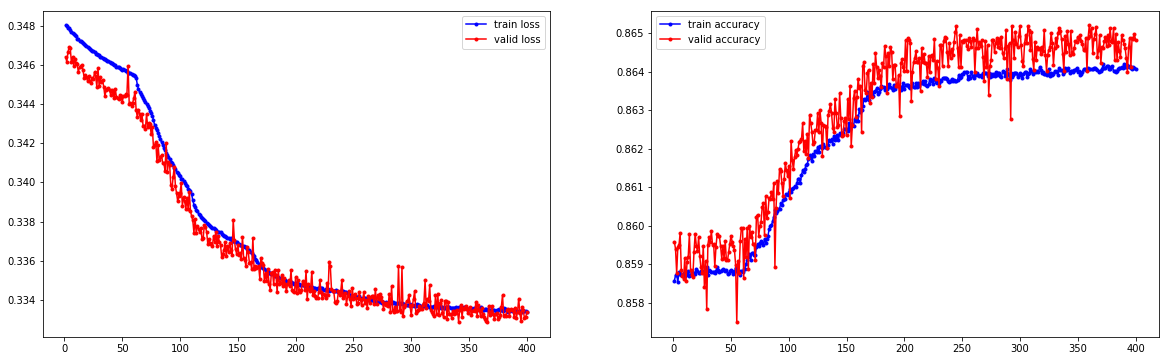

In [68]:
run_history_all = {}
run_history_all["epoch_loss_train"] = run_hist["epoch_loss_train"] + run_hist_2["epoch_loss_train"] 
run_history_all["epoch_loss_valid"] = run_hist["epoch_loss_valid"] + run_hist_2["epoch_loss_valid"] 
run_history_all["epoch_acc_train"] = run_hist["epoch_acc_train"] + run_hist_2["epoch_acc_train"] 
run_history_all["epoch_acc_valid"] = run_hist["epoch_acc_valid"] + run_hist_2["epoch_acc_valid"] 


plot_training_classification(run_history_all)

In [81]:
def print_roc(model, X, Y):
    X = torch.tensor(X.values, dtype=torch.float).to(device)
    output =  model(X)    
    plt.figure(figsize=[6, 6])
    fpr, tpr, thresholds = roc_curve(Y, output.cpu().detach().numpy()[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC 2NN (area = %0.2f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



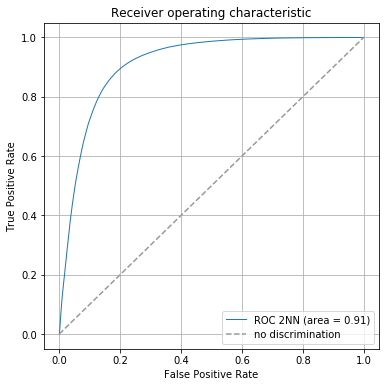

In [93]:
print_roc(model,X_valid, Y_valid )

In [71]:
for param in model. ():
  print(param.data)


('l1.weight', Parameter containing:
tensor([[ -0.1367,   1.1124,  -1.1708,   0.0447,   0.0820,   0.0834,   0.0217,
           0.0262,  -0.0292,  -0.0186,   0.1090,  -1.2418,   0.3045,   1.5453,
          -0.3212,  -0.0685],
        [  0.0063,   2.3679,   1.0312,   0.1412,  -0.1297,  -0.0416,   0.0148,
          -0.0167,  -0.0044,   0.0141,   1.6976,  -1.1933,  -0.5331,  -0.0904,
           0.3315,  -1.4060],
        [ -0.0235,  -2.6934,  -2.1472,   0.0450,   0.0390,  -0.0034,  -0.3295,
           0.0331,  -1.4814,  -0.0242,  -0.2090,   0.5508,  -0.7394,  -0.0935,
          -0.6640,   0.4465],
        [ -0.0856,   1.1458,   1.0093,   0.0969,  -0.0251,   0.0179,  -0.0086,
          -0.4250,  -0.0069,   2.2054,  -0.1531,  -1.8126,   0.2295,   0.4486,
          -0.2080,  -0.0369],
        [  0.0280,   0.3497,  -0.8451,  -0.0245,  -0.0212,  -0.0006,   0.0087,
          -0.0001,  -0.0045,   0.0072,  -0.1959,   2.5230,   0.0591,  -2.1830,
           0.2720,  -0.1115],
        [ -0.0638,  -0.3